### Regge-Wheeler-Zerilli Evolution | Adaptive Characteristic Method
**Author**: Ken Sible | **Date**: May 8, 2019

<img src="images/adaptive_figure.png" width="2236" height="1258" align="center"/>

**Adaptive Characteristic Method Algorithm**

\begin{align}
    \text{Lower Resolution: }&\psi^{(LR)}\,(i\rightarrow i+1)\\
    \text{Higher Resolution, 1: }&\psi^{(HR,1)}\,(i\rightarrow i+1/2)\\
    \text{Higher Resolution, 2: }&\psi^{(HR,2)}\,(i+1/2\rightarrow i+1)
\end{align}
~~~~
# Define Constants, Functions, and Initial Conditions
while u[i] < u_max
    # Compute ψLR, ψHR[1], ψHR[2]
    ϵ = maximum(abs.(ψHR[2] - ψLR))
    if ϵ < tol
        push(ψ, ψLR)
        push(u, u[i] + du)
        i += 1
    end
    du *= (tol/ϵ)^(1/2)
end
~~~~

In [1]:
""" lambertw(z, [tol])

    Solves z = w * exp(w) for w using the Newton-Raphson method
    with the specified tolerance, assuming the principle branch.
"""
function lambertw(z::Number; tol::Real=1e-8)
    z < -1/ℯ && throw(DomainError())
    f(w) = w * exp(w) - z
    df(w) = exp(w) * (w + 1)
    w = z < 1 ? z : log(z)
    f(w) == 0 && return w
    begin i = 0
        while abs(f(w)) > tol
            w += -f(w)/df(w)
            (i += 1) > 1000 && break
        end
    end
    return w
end;

In [2]:
function rtwavefunc(tspan::NTuple{2, Real}, xspan::NTuple{2, Real},
        dt::Real, dx::Real, x0::Real)
    (ti, tf), (xi, xf) = tspan, xspan
    t, x = ti:dt:tf, xi:dx:xf
    Nt, Nx = length(t), length(x)
    
    s, l = 3, 3 # Spin, Angular Momentum (l ≥ s)
    # V(r) = (1 - 1/r)*((l + 1)l/r^2 + (1 - s^2)/r^3)
    V(r) = (1 - 2/r)*((l + 1)l/r^2 - 6/r^3)
    radial(x) = 2(lambertw(exp((x - 2)/2)) + 1)
    r = radial.(x) # Radial Coordinate (r_s = 1)

    ψ = zeros(Nt, Nx, 2) # Numerical Solution
    gauss(x) = 0.5(exp(-(x - x0)^2/10))
    ψ[1, :, :] = hcat(gauss.(x), 2*0.1(x0 .- x) .* gauss.(x))
    
    # ψtt - ψxx + V(r)ψ = 0 | let ψ[1] = ψ, ψ[2] = ψt
    rhs(t, ψ, r, ψxx) = [ψ[2], ψxx - V(r) * ψ[1]]
    
    ψxx, ψ1 = zeros(Nx), zeros(Nx, 2)
    k1, k2 = zeros(Nx, 2), zeros(Nx, 2)
    for i = 1:(Nt - 1) # Ralston's Method
        for j = 2:(Nx - 1)
            ψxx[j] = (ψ[i, j + 1, 1] - 2ψ[i, j, 1] + ψ[i, j - 1, 1])/dx^2
            k1[j, :] = rhs(t[i], ψ[i, j, :], r[j], ψxx[j])
            ψ1[j, :] = ψ[i, j, :] + k1[j, :]*(2/3)*dt
        end
        for j = 2:(Nx - 1)
            ψxx[j] = (ψ1[j + 1, 1] - 2ψ1[j, 1] + ψ1[j - 1, 1])/dx^2
            k2[j, :] = rhs(t[i] + (2/3)*dt, ψ1[j, :], r[j], ψxx[j])
            ψ[i + 1, j, :] = ψ[i, j, :] + dt*(k1[j, :] + 3*k2[j, :])/4
        end
    end

    return ψ[:, :, 1], t, x
end;

In [3]:
function uvwavefunc(uspan::NTuple{2, Real}, vspan::NTuple{2, Real},
        du::Real, dv::Real, v0::Real, ψ0::Vector{<:Real}; tol=1e-6)
    (ui, uf), (vi, vf) = uspan, vspan
    v = vi:dv:vf; Nv = length(v)
    
    s, l = 3, 3 # Spin, Angular Momentum (l ≥ s)
    # V(r) = (1 - 1/r)*((l + 1)l/r^2 + (1 - s^2)/r^3)
    V(r) = (1 - 2/r)*((l + 1)l/r^2 - 6/r^3)
    r(x) = 2(lambertw(exp((x - 2)/2)) + 1)

    i, u = 1, [Float64(ui)]
    ψ = zeros(1, Nv); ψ[1, :] = ψ0
    ψLR, ψHR = zeros(Nv), zeros(2, Nv)

    while u[i] < uf
        for j = 1:(Nv - 1)
            x = ((v[j + 1] + v[j]) - ((u[i] + du) + u[i]))/4
            α = 1 - (du * dv)/8 * V(r(x))
            ψLR[j + 1] = α * (ψLR[j] + ψ[i, j + 1]) - ψ[i, j]

            x = ((v[j + 1] + v[j]) - ((u[i] + du/2) + u[i]))/4
            α = 1 - (du/2 * dv)/8 * V(r(x))
            ψHR[1, j + 1] = α * (ψHR[1, j] + ψ[i, j + 1]) - ψ[i, j]

            x = ((v[j + 1] + v[j]) - ((u[i] + du) + (u[i] + du/2)))/4
            α = 1 - (du/2 * dv)/8 * V(r(x))
            ψHR[2, j + 1] = α * (ψHR[2, j] + ψHR[1, j + 1]) - ψHR[1, j]
        end
        ϵ = maximum(abs.(ψHR[2, :] - ψLR))
        if ϵ < tol
            ψ = [ψ; ψLR']
            push!(u, u[i] + du)
            i += 1
        end
        du *= (tol/ϵ)^(1/2)
    end

    return ψ, u, v
end;

The characteristic coordinates are defined as $(u,v)=(t-x,t+x)$ where $x\equiv r_*$. We observe that inverting the linear coordinate transformation along the v-axis produces $\Delta v=2\Delta x$. Let $x_0$ denote the initial pulse position for the $(x,t)$ coordinate system. After the $(x,t)$ evolution proceeds from $0\leq t\leq 50$, we define the solution along the curve $x-t=x_0-50$ as the initial condition for the characteristic method. From this particular definition, we see that $v_0=50+(x_0-50)=x_0$, $50-x_0\leq u\leq t_f$, and $v_0-50\leq v\leq v_0+50$.

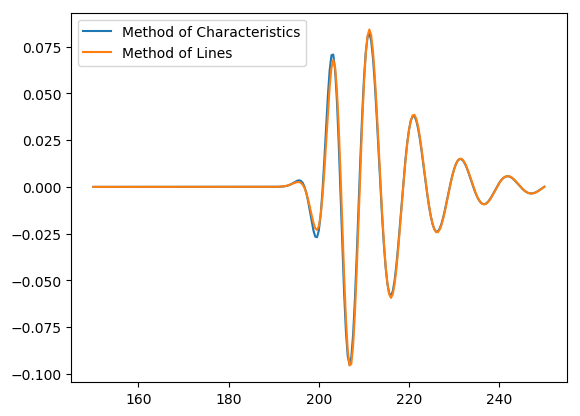

In [4]:
using PyPlot

dx = 0.2; dt = 0.2dx; x0 = 200
tspan, xspan = (0, 300), (-250, 250)

du = dv = 0.4; v0 = 200
uspan, vspan = (-100, 300), (150, 250)

ψrt, t, x = rtwavefunc(tspan, xspan, dt, dx, x0)

ψIS, ψFS = Float64[], Float64[]
(ui, uf), (vi, vf) = uspan, vspan
for i = 1:length(t), j = 1:length(x)
    u = round(t[i] - x[j], digits=2)
    v = round(t[i] + x[j], digits=2)
    if vi <= v <= vf
        u == ui && push!(ψIS, ψrt[i, j])
        u == uf && push!(ψFS, ψrt[i, j])
    end
end

ψuv, u, v = uvwavefunc(uspan, vspan, du, dv, v0, ψIS)

plot(v, ψuv[end, :], label="Method of Characteristics")
plot(v, ψFS, label="Method of Lines"); plt.legend();